In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import matplotlib

In [3]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

In [4]:
path = Path("/data/Datasets/EIPH_WSI/HumanExpert/Predictions/")
gt_path = Path("/data/Datasets/EIPH_WSI/HumanExpert/GT/")

In [5]:
file_to_id = {}
id = 0

gt = []
for file in glob(str(gt_path/'*/*.bmp')):
    file = Path(file)

    label = int(file.parent.stem)
    gt.append(label)

    file_to_id[file.stem] = id
    id += 1

gt = np.array(gt)

In [6]:
results_vo = {}
results_v1 = {}

for file in glob(str(path/'*')):
    file = Path(file)
    reviewer = file.name
    
    results_vo[reviewer] = np.zeros_like(gt)
    results_v1[reviewer] = np.zeros_like(gt)

    for cell_path in glob(str(file/'v0/*/*.bmp')):
        cell_path = Path(cell_path)

        id = file_to_id[cell_path.stem]
        results_vo[file.stem][id] = int(cell_path.parent.stem)
        
    for cell_path in glob(str(file/'v1/*/*.bmp')):
        cell_path = Path(cell_path)

        id = file_to_id[cell_path.stem]
        results_v1[file.stem][id] = int(cell_path.parent.stem)

### ACC

In [7]:
regression_gt = np.mean(gt)
regression_gt

1.4775

In [8]:
data_acc = []
data_regression = []

for reviewer in results_vo:
    prediction_vo = results_vo[reviewer]
    prediction_v1 = results_v1[reviewer]
    
    score_v0 = np.mean(prediction_vo) - regression_gt
    score_v1 = np.mean(prediction_v1) - regression_gt
    
    data_acc.append([reviewer, accuracy_score(gt, prediction_vo), accuracy_score(gt, prediction_v1), cohen_kappa_score(prediction_vo, prediction_v1)])
    data_regression.append([reviewer, score_v0, score_v1])
    
 
data_acc

[['DL_Regression', 0.847, 0.847, 1.0],
 ['DL_Classification', 0.848, 0.848, 1.0],
 ['Jabari_Samir', 0.7865, 0.273, 0.0],
 ['Svenja', 0.6855, 0.273, 0.0],
 ['JensK', 0.7335, 0.273, 0.0]]

In [9]:
df_acc = pd.DataFrame(data_acc, columns = ['Name', 'V0', 'V1', 'Kappa']) 
df_reg = pd.DataFrame(data_regression, columns = ['Name', 'V0', 'V1']) 
df_acc

,Name,V0,V1,Kappa
0,DL_Regression,0.8470,0.847,1.0
1,DL_Classification,0.8480,0.848,1.0
2,Jabari_Samir,0.7865,0.273,0.0
3,Svenja,0.6855,0.273,0.0
4,JensK,0.7335,0.273,0.0


In [10]:
df_reg

,Name,V0,V1
0,DL_Regression,0.028,0.0280
1,DL_Classification,0.010,0.0100
2,Jabari_Samir,0.056,-1.4775
3,Svenja,0.275,-1.4775
4,JensK,0.205,-1.4775


In [11]:
df_acc.values.tolist()

[['DL_Regression', 0.847, 0.847, 1.0],
 ['DL_Classification', 0.848, 0.848, 1.0],
 ['Jabari_Samir', 0.7865, 0.273, 0.0],
 ['Svenja', 0.6855, 0.273, 0.0],
 ['JensK', 0.7335, 0.273, 0.0]]

In [12]:
symbols = {"Jabari_Samir": "4",  
           "DL_Regression": "<",
           "DL_Classification": ">",
           "Svenja": 'D',
              "JensK": 'D',}

color = {"Jabari_Samir": "r",  
           "DL_Regression": "b",
           "DL_Classification": "b",
           "Svenja": 'm',
            "JensK": 'm',}



In [13]:
temp_data = pd.melt(df_acc[['V0', 'V1']])
temp_data = temp_data.astype({"value": float, "variable": str})
temp_data

,variable,value
0,V0,0.8470
1,V0,0.8480
2,V0,0.7865
3,V0,0.6855
4,V0,0.7335
5,V1,0.8470
6,V1,0.8480
7,V1,0.2730
8,V1,0.2730
9,V1,0.2730


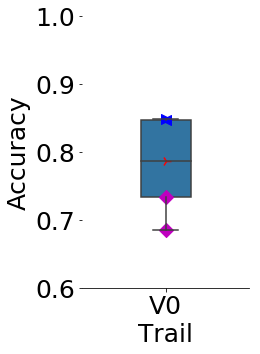

In [52]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 25

f, ax = plt.subplots(figsize=(3, 5))

temp_data = pd.melt(df_acc[['V0']]) #, 'V1'
ax = sns.boxplot(x="variable", y="value", data=temp_data, width=.3)
ax.set(ylim=(0.6, 1))

for index, row in enumerate(df_acc.values.tolist()):
    name = row[0]
    acc_0 = row[1]
    acc_1 = row[2]
    
    plt.scatter(x=0, y=acc_0,marker=symbols[name], label=name, s=100, c=color[name])
    plt.scatter(x=1, y=acc_1,marker=symbols[name], s=100, c=color[name])


#ax.xaxis.grid(True)
#ax.yaxis.grid(True)
#ax.legend(bbox_to_anchor=(1.45, 0.8), prop={'size': 25}, frameon=False)

ax.set(ylabel="Accuracy", xlabel="Trail")
sns.despine(left=True)

plt.savefig("AccuracyExperts.pdf", transparent=True)

In [47]:
df_acc[['Kappa']]

,Kappa
0,1.0
1,1.0
2,0.0
3,0.0
4,0.0


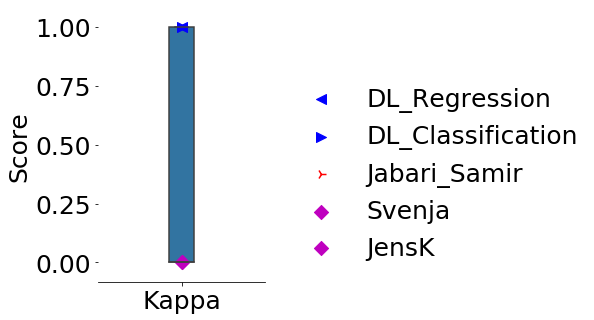

In [48]:
f, ax = plt.subplots(figsize=(3, 5))

temp_data = pd.melt(df_acc[['Kappa']])
ax = sns.boxplot(x="variable", y="value", data=temp_data, width=.15)

for index, row in enumerate(df_acc.values.tolist()):
    name = row[0]
    kappa = row[3]
    
    plt.scatter(x=0, y=kappa, marker=symbols[name], label=name, s=100, c=color[name])


#ax.xaxis.grid(True)
#ax.yaxis.grid(True)
ax.legend(bbox_to_anchor=(1.05, 0.8), prop={'size': 25}, frameon=False)

ax.set(ylabel="Score", xlabel="")
sns.despine(left=True)

plt.savefig("KappaScore.pdf", transparent=True)

In [49]:
regression_gt

1.4775

In [50]:
df_reg

,Name,V0,V1
0,DL_Regression,0.028,0.0280
1,DL_Classification,0.010,0.0100
2,Jabari_Samir,0.056,-1.4775
3,Svenja,0.275,-1.4775
4,JensK,0.205,-1.4775


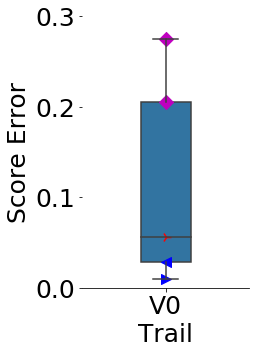

In [51]:
f, ax = plt.subplots(figsize=(3, 5))

temp_data = pd.melt(df_reg[['V0']])# , 'V1'
ax = sns.boxplot(x="variable", y="value", data=temp_data, width=.3)
ax.set(ylim=(0, 0.3))

for index, row in enumerate(df_reg.values.tolist()):
    name = row[0]
    acc_0 = row[1]
    acc_1 = row[2]
    
    plt.scatter(x=0, y=acc_0,marker=symbols[name], label=name, s=100, c=color[name])
    plt.scatter(x=1, y=acc_1,marker=symbols[name], s=100, c=color[name])


#ax.xaxis.grid(True)
#ax.yaxis.grid(True)
#ax.legend(bbox_to_anchor=(1.05, 0.8), prop={'size': 25},frameon=False)

ax.set(ylabel="Score Error", xlabel="Trail")
sns.despine(left=True)

plt.savefig("RegressionError.pdf", transparent=True)